In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
from diffusion_models import Weighted_Cascade, Trivalency_Model, Independent_Cascade, Decreasing_Cascade, linear_threshold, general_threshold
import pandas as pd
from influence_max_algorithms import MIA


In [4]:
pb2020 = nx.read_gml('/Users/davidguzman/Documents/GitHub/Network-Science-final-Maximization-/Proud_Boys_Datsets/PB2020.gml')

In [5]:
#invert edge direction for PB2020
pb2020 = pb2020.reverse()

In [7]:
#number of nodes and edges
print("Number of nodes: ", pb2020.number_of_nodes())
print("Number of edges: ", pb2020.number_of_edges())

Number of nodes:  13217
Number of edges:  14477


In [8]:
weighted_cascade_model_2020 = Weighted_Cascade()
weighted_cascade_model_2020.fit(pb2020)

In [9]:
seed = ['principe_giovan',
 'Premises187',
 'MoralDK',
 'proudboy_',
 'enrique_tarrio',
 'GavinM_ProudBoy',
 'proudboy2012',
 'ProudBoysGBG',
 'ProudBoysUS',
 'ProudBoyzLondon',
 'ColoradoPOYB',
 'DetroitProudBoy',
 'Father_Rhyme',
 'Proudboy13',
 'IStand4Trump',
 'RallyPb',
 'mtn_pb',
 'Darktwistysnow',
 'mike29401',
 'demonik81',
 'Awful_Right',
 'BiomassMonitor',
 'my40thaccount',
 'TheFaction1776',
 'MediaRival',
 'KitDaniels1776',
 'LeeAnnMcAdoo',
 'libertytarian',
 'PrisonPlanet',
 'Cernovich',
 'ObamaMalik',
 'Lauren_Southern',
 'realDonaldTrump',
 'barstoolsports',
 'arielhelwani',
 'Qanon76',
 'TheNotoriousMMA',
 'TuckerCarlson',
 'DiamondandSilk',
 'seanhannity',
 'IngrahamAngle',
 'DineshDSouza',
 'w_terrence',
 'RepStevenSmith',
 'benshapiro',
 'RealCandaceO',
 'DonaldJTrumpJr',
 'IvankaTrump',
 'ZachZorlac',
 'DeusLingo',
 '28272209C',
 'Trump760',
 'Joe_Runge',
 'MikeMaroney11',
 'LolatheDoodette',
 'D0doubleD',
 'Schwa507',
 'NirajAryal20',
 'Barbarian_Bunny',
 'Prole357',
 'PavelMikoloski',
 'g28308990',
 'pastorfu',
 'P8riotPreacher',
 'iambryan_v',
 'Damien812',
 'katkozitza',
 'AdamsHasten',
 'owl_breath',
 'rickthetrollwh1',
 'Sinatra1fan',
 'hurricanefiend8',
 'shellie647',
 'Boon81914337',
 'ssgortizjorge',
 'InterchangeWdk',
 'JakeLedoux',
 'CASH9229',
 'recgildersleeve',
 'AZPatriotWife',
 'RandyB931',
 'Cali11958322',
 'LIZAIDA',
 'Allenglen14',
 'LMN7111',
 '_Death_Hack_',
 'nycshoot',
 'kcgreen77',
 'Hank_Rudr',
 'jeffhanson9',
 'TheRealNicoleG1',
 '_miLo',
 'paperboy311',
 'PutinKills',
 'Aghaveagh',
 'JoeMendi1',
 'Dingus118',
 'Dolla_bill2',
 'iam_marci',
 'KittenSlayer179']

In [27]:
#get the attributes of the nodes whose labels are in the seed
seed_nodes = [pb2020.nodes[node] for node in seed]
# for the nodes in seed_nodes, get all attributes and store them in a pandas dataframe
seed_nodes_df = pd.DataFrame(seed_nodes)
#add the labels of the nodes to the dataframe as the first column
seed_nodes_df.insert(0, 'label', seed)


In [28]:
#drop all columns after the statuses
seed_nodes_df = seed_nodes_df.iloc[:, :6]
#drop all rows that have a NaN value
seed_nodes_df = seed_nodes_df.dropna()


In [29]:
new_seed = seed_nodes_df['label'].tolist()

In [30]:
individual_influence = []
for label in new_seed:
    activate_nums = weighted_cascade_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence.append(sum(activate_nums))

In [31]:
seed_nodes_df['influence_wcm'] = individual_influence

In [36]:
seed_nodes_df.head(30)

,label,faves,followers,friends,listed,statuses,influence_wcm
0,principe_giovan,8253.0,625.0,605.0,6.0,693.0,554.18
2,MoralDK,14609.0,216.0,322.0,5.0,6421.0,238.87
7,ProudBoysGBG,407.0,48.0,50.0,1.0,213.0,42.29
8,ProudBoysUS,604.0,3096.0,44.0,12.0,482.0,35.00
10,ColoradoPOYB,1.0,12.0,9.0,1.0,5.0,6.83
14,IStand4Trump,859.0,5068.0,5124.0,35.0,21071.0,1.51
15,RallyPb,1.0,133.0,186.0,0.0,10.0,1.61
16,mtn_pb,5311.0,317.0,431.0,0.0,514.0,1.69
17,Darktwistysnow,1327.0,54.0,349.0,0.0,2436.0,1.89
18,mike29401,49210.0,10139.0,27364.0,175.0,53475.0,4.71


In [35]:
#cut all rows with influence equal or less than 1
seed_nodes_df = seed_nodes_df[seed_nodes_df['influence_wcm'] > 1]

'\nimport seaborn as sns\nsns.set_theme(style="ticks")\nsns.pairplot(seed_nodes_df, hue="label")\n'

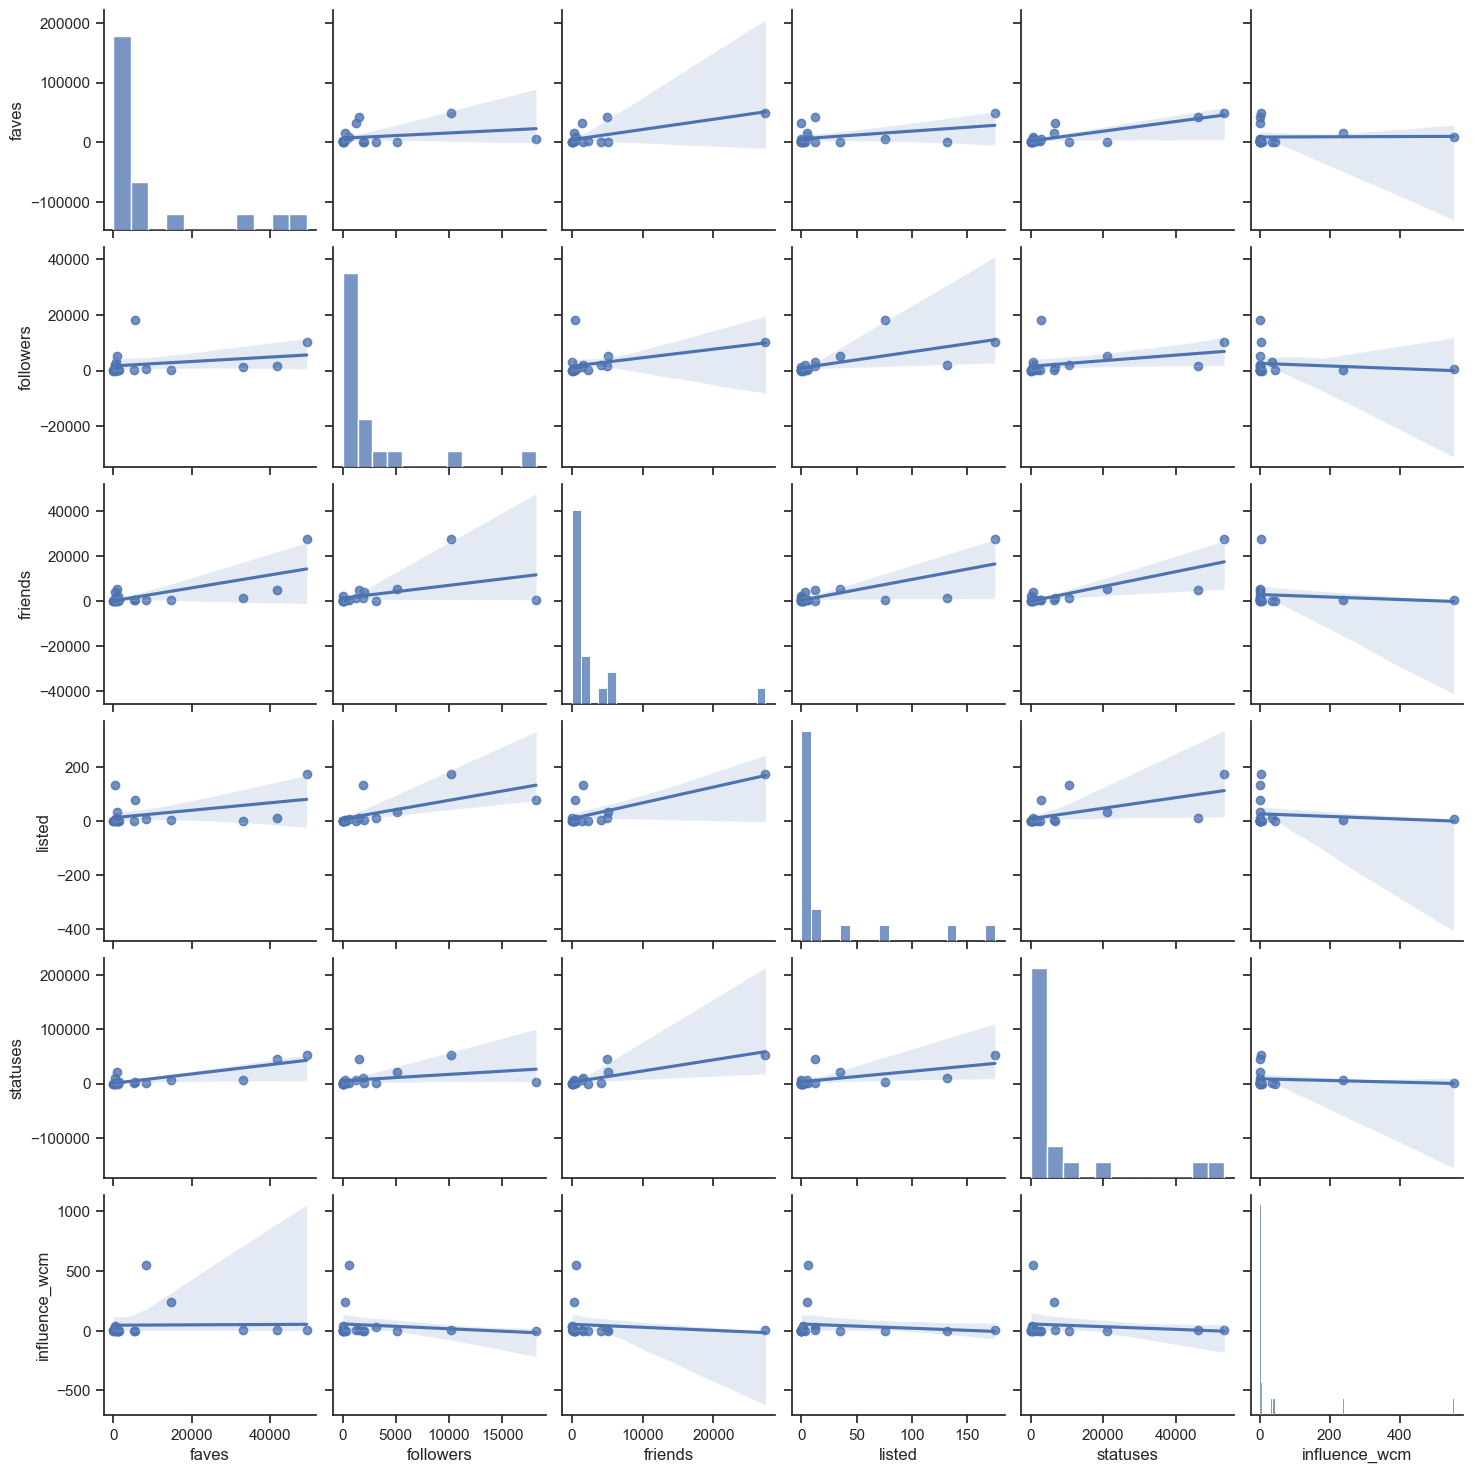

In [41]:
# plot scatterplots for each attribute in one plot wiht seaborn with correlation lines and coefficients numbers added to the plot
import seaborn as sns
sns.pairplot(seed_nodes_df, kind="reg")
 
"""
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(seed_nodes_df, hue="label")
"""

In [42]:
#print correlation matrix
seed_nodes_df.corr()

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_13600/640525702.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  seed_nodes_df.corr()


,faves,followers,friends,listed,statuses,influence_wcm
faves,1.000000,0.265756,0.700701,0.423934,0.836420,0.017281
followers,0.265756,1.000000,0.418490,0.631398,0.342067,-0.138486
friends,0.700701,0.418490,1.000000,0.732089,0.817835,-0.119033
listed,0.423934,0.631398,0.732089,1.000000,0.613285,-0.130274
statuses,0.836420,0.342067,0.817835,0.613285,1.000000,-0.131813
influence_wcm,0.017281,-0.138486,-0.119033,-0.130274,-0.131813,1.000000


## now using the Incinf of MIA

In [6]:
mia = MIA(pb2020)

In [12]:
def assing_model_probs_to_weights(model):
    pb2020_model = pb2020.copy()
    for edge in pb2020_model.edges():
        prob = model.probability[model.label2id[edge[0]], model.label2id[edge[1]]]

        if pb2020_model.in_degree(edge[0]) == 0: # to avoid division by 0

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob + 0.00000001)) # to avoid diverging to - infinity
        else:

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob))
    return pb2020_model

In [13]:
pb2020_weighted_cascade = assing_model_probs_to_weights(weighted_cascade_model_2020)

In [17]:
Incinf = mia.initial_incinf(pb2020_weighted_cascade, 0.1)

Starting MIA intialization


100%|██████████| 13217/13217 [00:42<00:00, 309.40it/s]


In [21]:
Incinf

[('principe_giovan', 548.6111111111111),
 ('Premises187', 346.1111111111111),
 ('MoralDK', 232.61111111111114),
 ('proudboy_', 192.11111111111111),
 ('enrique_tarrio', 102.77777777777776),
 ('GavinM_ProudBoy', 94.36111111111111),
 ('proudboy2012', 63.0),
 ('ProudBoysGBG', 41.25),
 ('ProudBoysUS', 34.0),
 ('ProudBoyzLondon', 13.833333333333332),
 ('DetroitProudBoy', 8.194444444444443),
 ('Father_Rhyme', 6.277777777777778),
 ('ColoradoPOYB', 5.861111111111111),
 ('JPreziose', 4.388888888888889),
 ('dick_esq', 4.388888888888889),
 ('BlackBrWriting', 4.388888888888889),
 ('Proudboy13', 2.0),
 ('mike29401', 1),
 ('MediaRival', 1),
 ('KitDaniels1776', 1),
 ('LeeAnnMcAdoo', 1),
 ('libertytarian', 1),
 ('PrisonPlanet', 1),
 ('Cernovich', 1),
 ('ObamaMalik', 1),
 ('Lauren_Southern', 1),
 ('realDonaldTrump', 1),
 ('barstoolsports', 1),
 ('arielhelwani', 1),
 ('Qanon76', 1),
 ('TheNotoriousMMA', 1),
 ('TuckerCarlson', 1),
 ('DiamondandSilk', 1),
 ('seanhannity', 1),
 ('IngrahamAngle', 1),
 ('Dine

In [20]:
#sort Incinf 
Incinf = sorted(Incinf.items(), key=lambda x: x[1], reverse=True)
Incinf

AttributeError: 'list' object has no attribute 'items'